# **Judul Mini Project CV :** **CV Pneumonia Classification**

NAMA KELOMPOK TIM KUNING :
1. Faradillah Ramadhanti
2. Nissa Aljannah
3. Muhamad Suhaedi
4. M Zulmi Wijiyanto
5. Rizki Gunawan
6. Satrya Darmawan





# **Download Dataset**

In [ ]:
# Modul impor yang disediakan oleh Google Colab untuk kebutuhan unggah file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nissaaljannah","key":"3c2aa7f50f59ff4d9ac2f5a5ab7c4a2a"}'}

In [ ]:
# Unduh dataset kaggle dan unzip file
# Klasifikasi gambar pneumonia dataset sumber: paultimothymooney/chest-xray-pneumonia
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# **Import Module/Library**

In [ ]:
# Mengimpor diperlukan perpustakaan dan paket Keras
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

# **Display Sample Image**

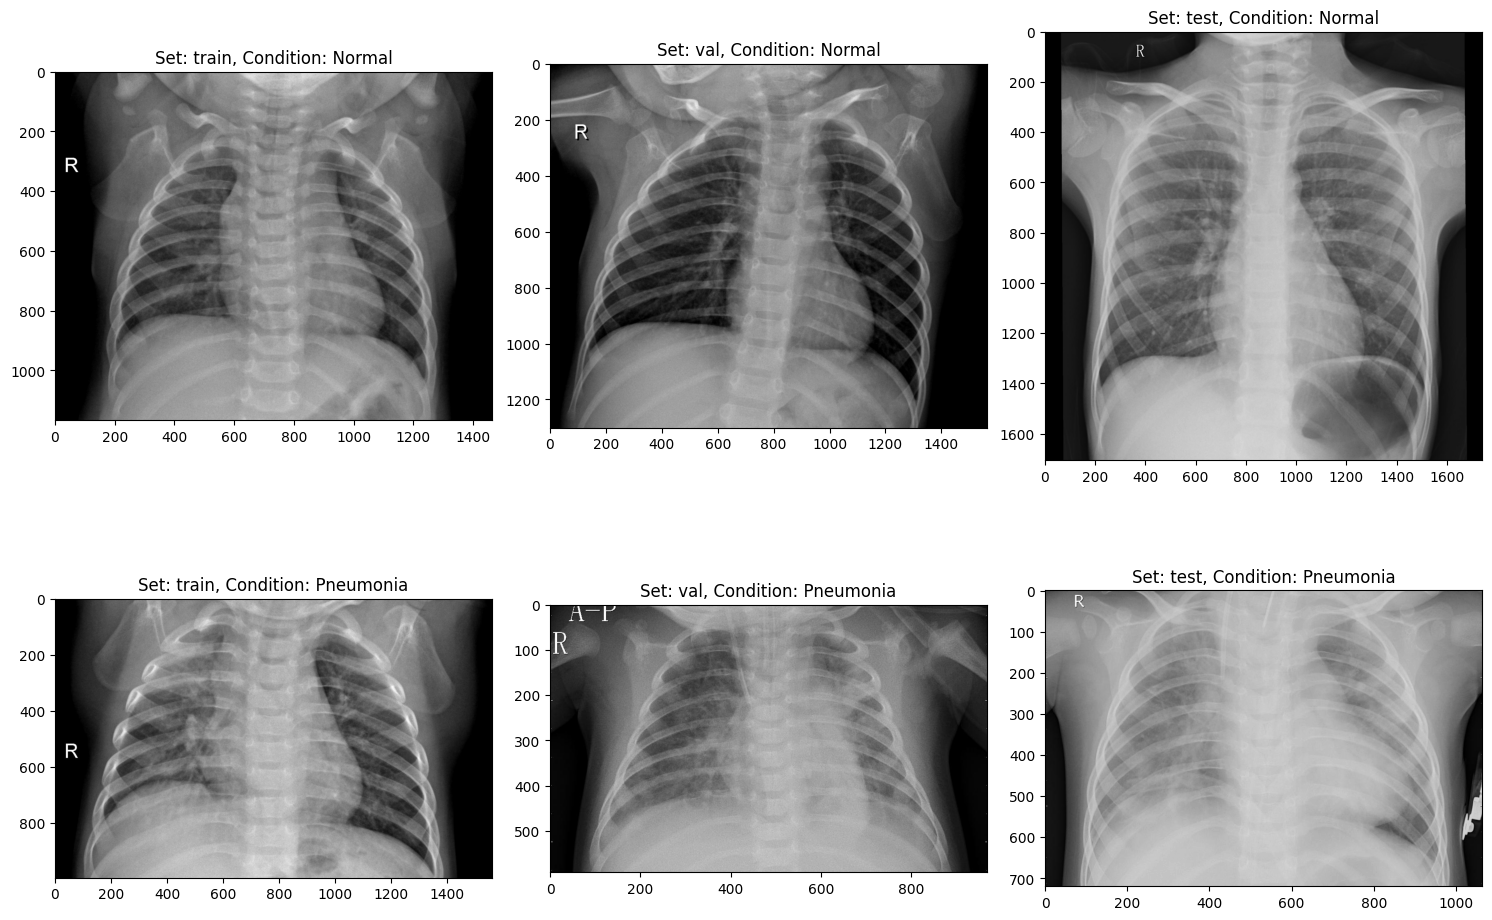

In [ ]:
filepath = 'chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = filepath + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))

    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# **Image Augmentation**

In [ ]:
# Atur dimensi gambar (tinggi, lebar)
img_dims = 150
# Tentukan jumlah zaman
epochs = 10
# Tentukan jumlah ukuran batch
batch_size = 32

def process_data(img_dims, batch_size):

    # Bangun generator gambar pelatihan dengan augmentasi data
    train_data_generator = ImageDataGenerator(rescale = 1./255,
                                              shear_range = 0.2,
                                              zoom_range = 0.2,
                                              horizontal_flip = True)

    # Bangun generator data gambar pengujian
    test_data_generator = ImageDataGenerator(rescale = 1./255)

    # Bangun set pelatihan dengan menggunakan generator data pelatihan
    train_gen = train_data_generator.flow_from_directory(directory= filepath + 'train',
                                                        target_size=(img_dims, img_dims),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        shuffle=True)

    # Bangun validasi dengan menggunakan generator data uji
    valid_gen = test_data_generator.flow_from_directory(directory= filepath + 'test',
                                                        target_size=(img_dims, img_dims),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        shuffle=True)

    # Bangun pengujian dengan menggunakan generator data pengujian
    test_gen = test_data_generator.flow_from_directory(directory= filepath + 'test',
                                                        target_size=(img_dims, img_dims),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        shuffle=True)


    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(filepath + 'test' + cond)):
            img = plt.imread(filepath + 'test' + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

# Jalankan fungsi proses data yang membawa img_dims dan parameter ukuran batch
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Build & Summary Architectur Model CNN**

In [ ]:
# Bangun model arsitektur CNN

# Input Layer
inputs = Input(shape=(img_dims, img_dims, 3))

# Blok konv kesatu
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Blok konv kedua
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Blok konv ketiga
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# # Blok konv keempat
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Blok konv kelima
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Lapisan Terhubung Sepenuhnya
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Keluaran layer
output = Dense(units=1, activation='sigmoid')(x)

# Kompilasi CNN
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ringkasan model arsitektur
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_16 (Separa  (None, 75, 75, 128)      8896      
 bleConv2D)                                                      
                                                                 
 separable_conv2d_17 (Separa  (None, 75, 75, 128)      1766

# **Training Model CNN**

In [ ]:
filepath="pneumonia-classifier-cnn.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

# Model/pelatihan pas
hist = model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                epochs=epochs, validation_data=test_gen,
                validation_steps=test_gen.samples // batch_size, callbacks=[callbacks_list])

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8363
Epoch 1: val_accuracy improved from -inf to 0.62171, saving model to pneumonia-classifier-cnn.h5
163/163 [==============================] - 105s 585ms/step - loss: 0.3762 - accuracy: 0.8363 - val_loss: 1.0090 - val_accuracy: 0.6217
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9176
Epoch 2: val_accuracy improved from 0.62171 to 0.62664, saving model to pneumonia-classifier-cnn.h5
163/163 [==============================] - 94s 579ms/step - loss: 0.2119 - accuracy: 0.9176 - val_loss: 1.8892 - val_accuracy: 0.6266
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9327
Epoch 3: val_accuracy did not improve from 0.62664
163/163 [==============================] - 91s 559ms/step - loss: 0.1859 - accuracy: 0.9327 - val_loss: 1.7357 - val_accuracy: 0.6201
Epoch 4/10
163/163 [==============================] - ETA: 0s

In [ ]:
# Final evaluation of the model
scores = model.evaluate(test_gen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Training Done")

20/20 [==============================] - 5s 265ms/step - loss: 0.3179 - accuracy: 0.9071
Accuracy: 90.71%
Training Done


# **Accuracy & Loss Graph**

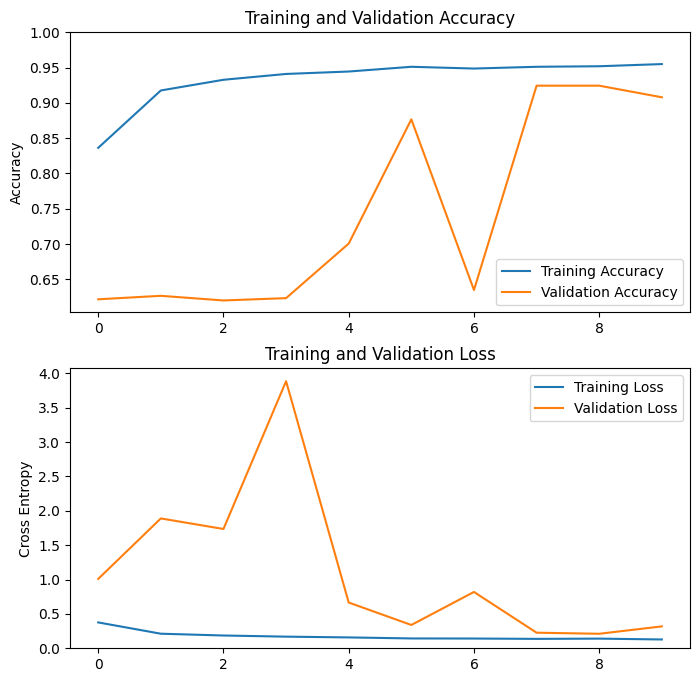

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# ------------------ Graph Accuracy  -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# --------------------- Graph Loss -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# **Testing Prediction**

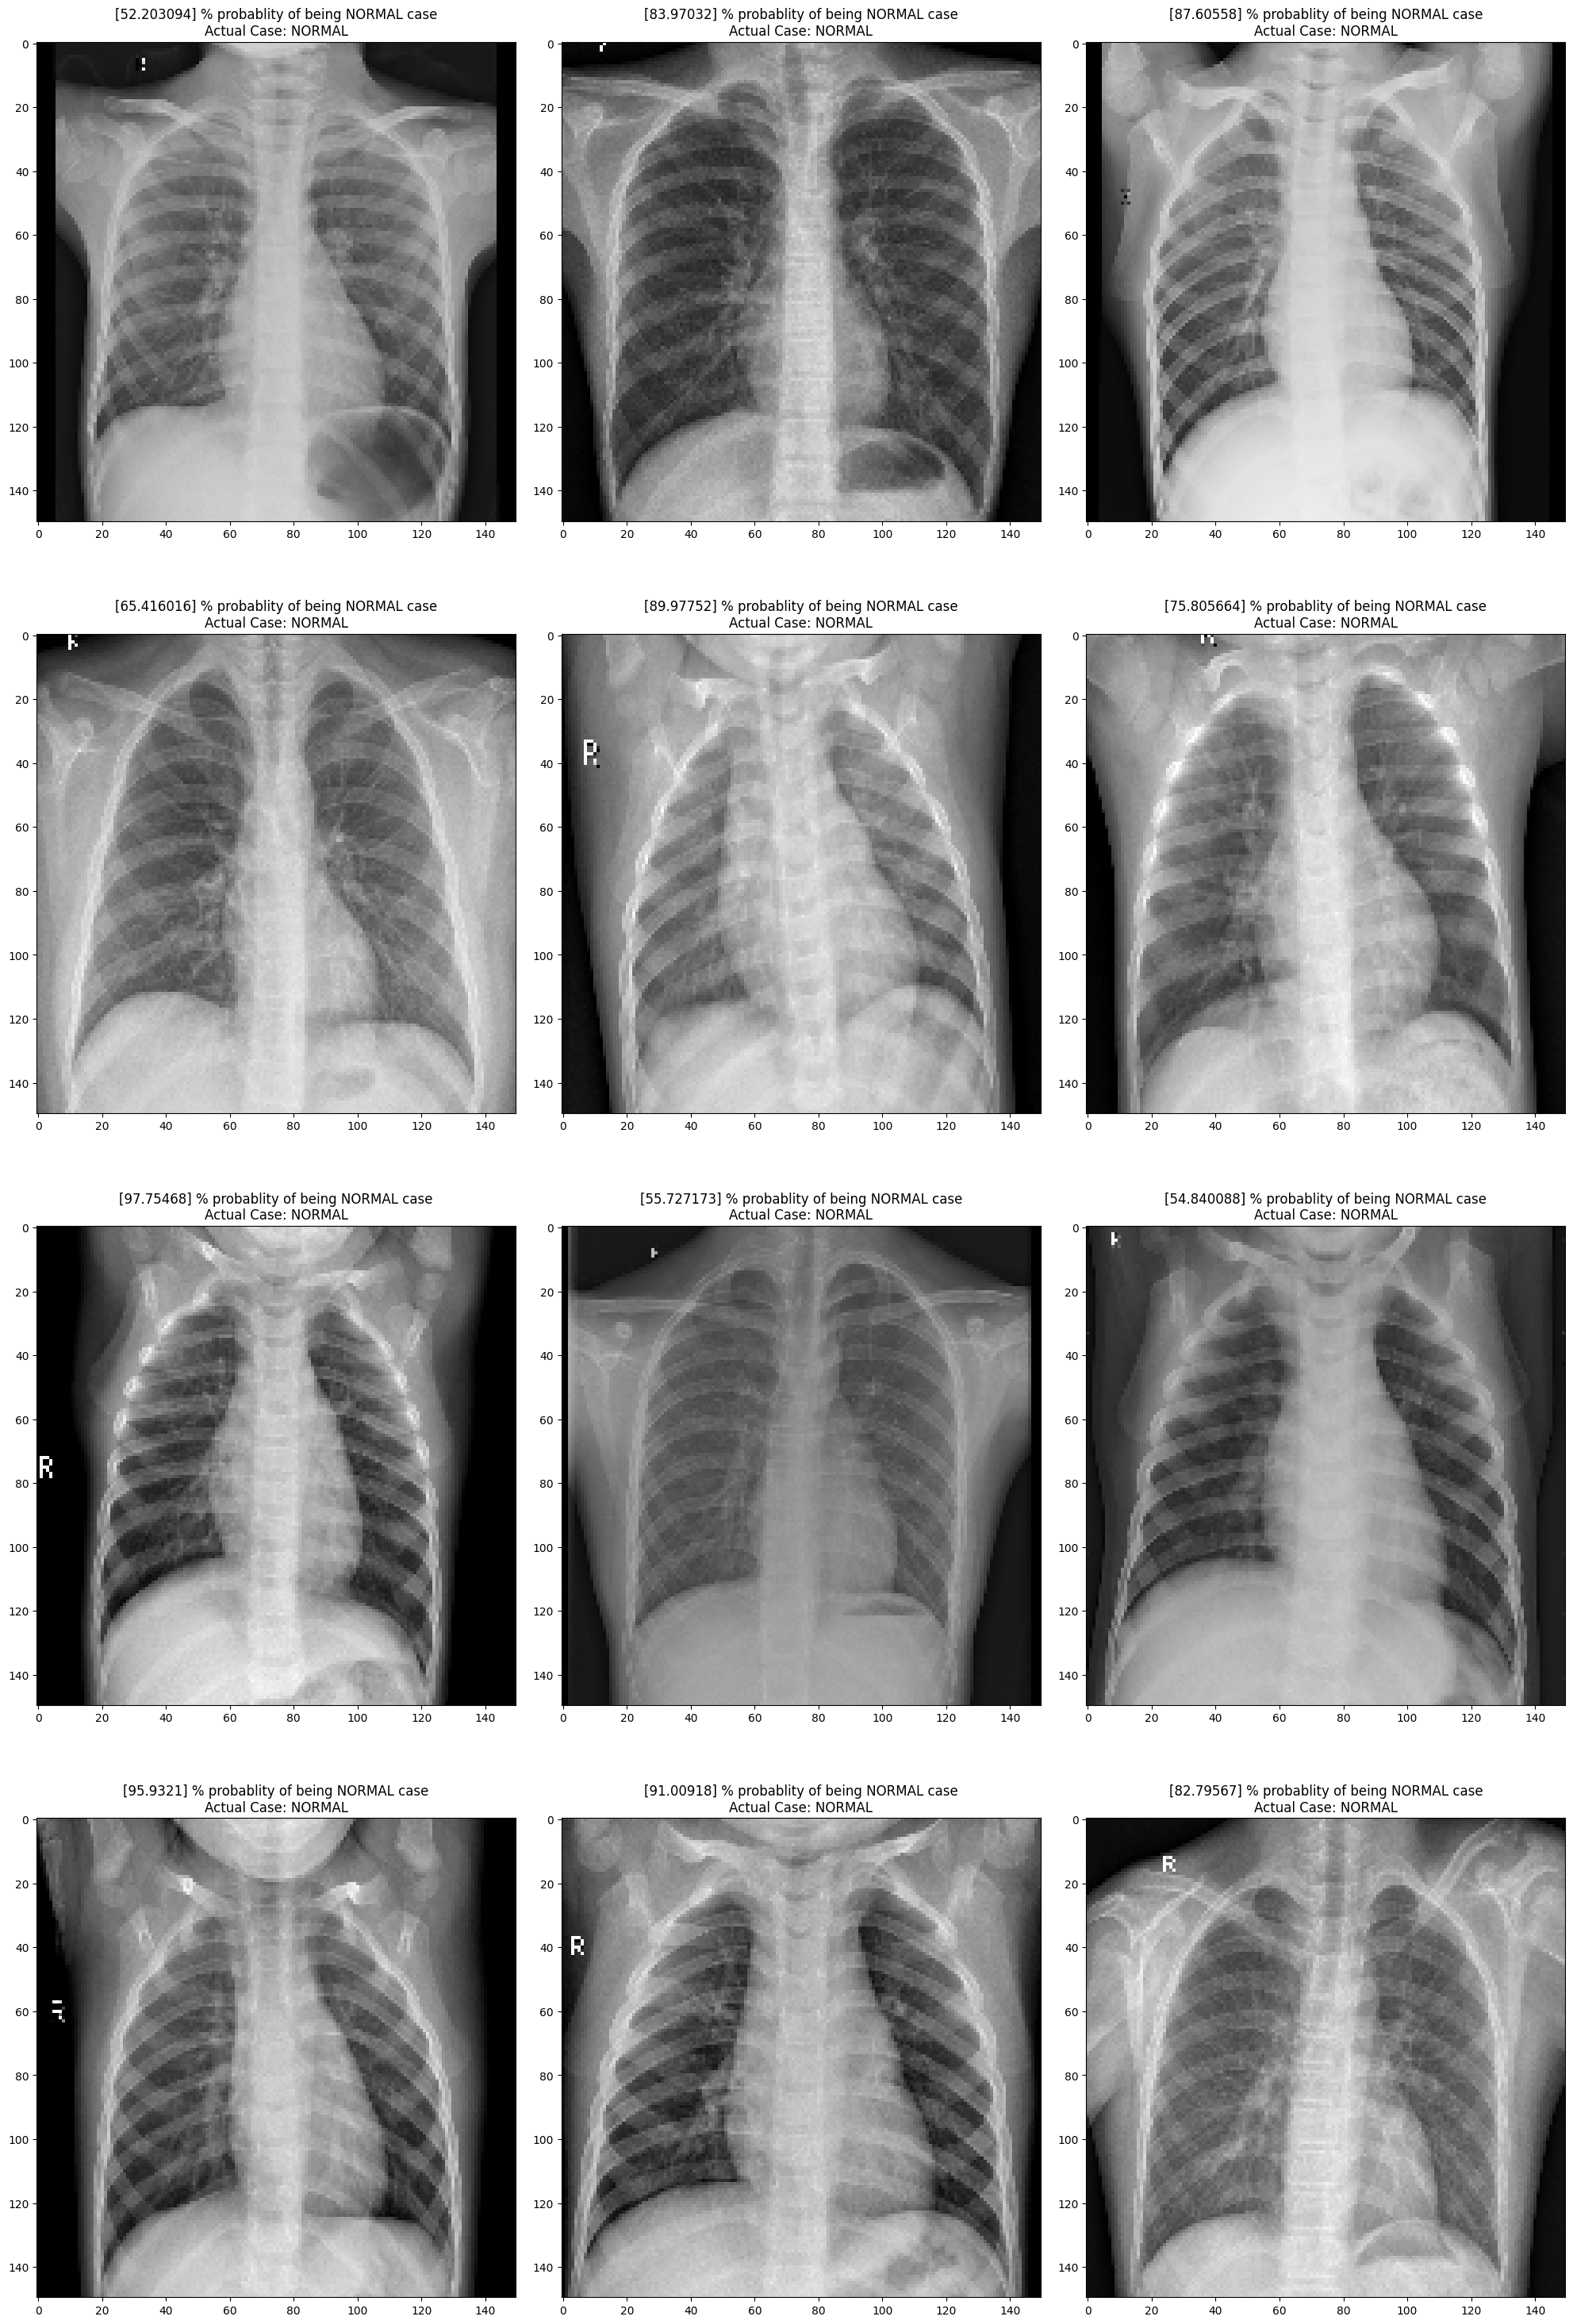

In [ ]:
preds = model.predict(test_data, verbose=0)

fig, ax = plt.subplots(4, 3, figsize=(20, 30))
ax = ax.ravel()
plt.tight_layout()

for i in range(12):
    ax[i].imshow(test_data[i], cmap='gray')

    if test_labels[i] == 0:
        ax[i].set_title('{} % probablity of being NORMAL case'.format((1 - preds[i])*100) + '\n' + 'Actual Case: NORMAL')
    else:
        ax[i].set_title('{} % probablity of being PNEUMONIA case'.format(preds[i]*100) + '\n' + 'Actual Case: PNEUMONIA')